In [ ]:
"""
Team Gopher Knowledge:
    Michael Ramsey, University of Colorado
    Hua Chen, University of Delaware
    Aaron Cohen, Indiana University
    Mingchang Ding, University of Delaware
    Melanie Jensen, Tulane University
    Christopher Miller, University of California, Berkeley
    
IMA Intro to Math Bootcamp: 6/1/18 - 7/20/18

Date Created: 6/1/18
Last Edited: 9/25/18

DESCRIPTION:
    This is a Python notebook to investigate the use of variational autoencoders in classifying the MNIST dataset.
    For this particular file, we subset the data to only classify zeros, ones, and twos.
    We project the orginal image space down to 50-dimensional latent space. In particular, for this file we 
    add convolutional layers to the autoencoder. We extract the feature vectors from the convolutional layers to
    use with Latent Dirichlet Allocation.

Much of this code is adapted from: http://pyro.ai/examples/vae.html
"""

# Classifying 0,1, and 2s

We consider the subset of digits ${0,1,2}$ to further analysize our VAE-CNN-LDA method. Specifically, we want to see how well our method does in classifying the image in terms of style (ie. digit thickness, slanted) and in terms of digit (0,1, or 2). To do this, we first train our VAE on the images labeled 0, 1, and 2s in the MNIST training set data, by maxmimizing the EBLO:
$$\text{ELBO} =.$$
Because we are only considering three digits, we set the dimension of latent space to be 10, $z_{dim}$. MOreover, we place a multivariate normal prior on $\vec{z}$ with mean vector zero and covariance matrix equal to the identity matrix. 
Our encoder is composed of a CNN in which we extract 32 'features'. These features can be thought as {\color{red}???and are what generate the words in our LDA model}.

We note that the follow can be modified so any three numbers in {0,1,2,3,4,5,6,7,8,9} can be classified. The parameters that select which subset we consider are $num_1$, $num\_2,$ and $num\_3$.

In [1]:
## Loading in the required modules
import os
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

import lda
import matplotlib.pyplot as plt

In [2]:
## Selecting the digits that make up our subset
num_1 = 0 
num_2 = 1
num_3 = 2

## Selecting the hyperparameters of the VAE
Z_DIM = 50
HIDDEN_DIM = 400

## Training Parameters

LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
# I adjust NUM_EPOCHS from 100 to 25

NUM_EPOCHS = 2 if smoke_test else 60
TEST_FREQUENCY = 5
BATCH_SIZE=256

LDA_iter = 2000


In [3]:
## Loading in the data and extracting num1, num2, and num3
root = './data'
trans = transforms.ToTensor() # This function converts the pixels to [0,1]
train_set_all = dset.MNIST(root=root, train=True,download=True,transform=trans)

train_subset = []
train_label = []
for j in range(len(train_set_all)):
    y = train_set_all[j][1]
    if (y== num_1) or (y ==  num_2) or (y == num_3):
        train_subset.append(train_set_all[j])
        train_label.append(y.detach())

test_set_all = dset.MNIST(root=root, train=False, transform=trans)
test_subset = []
test_label = []

for j in range(len(test_set_all)):
    y = test_set_all[j][1]
    if (y== num_1) or (y == num_2) or (y == num_3):
        test_subset.append(test_set_all[j])
        test_label.append(y.detach())


In [4]:
## Defining the encoding network
## The image need to be a tensor of size(1, 28,28)

# suppose the input image is (1,28,28)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        
        # first convolutional net
        self.conv1 = nn.Conv2d(1,4,kernel_size = 3,stride = 1, padding = 1)
        
        # second convolutional net
        self.conv2 = nn.Conv2d(4,8,kernel_size = 3,stride = 1,padding = 1)
        
        # third convolutional net
        self.conv3 = nn.Conv2d(8,16,kernel_size = 3,stride = 1,padding = 1)
        
        # fourth convolutional net
        self.conv4 = nn.Conv2d(16,32,kernel_size = 3,stride = 1,padding = 1)

        # pooling
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 3,stride = [2,2],padding = 0)
          
        #get a list of neural net components
        self.net_list =[]
        for i in range(0,32):
            self.net_list.append(nn.Linear(9,1))
        
        #This is the neural net part of our code.
        self.fc1 = nn.Linear(32, hidden_dim)    
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
#         # first shape the mini-batch to have pixels in the rightmost dimension
#         x = x.reshape(-1, 784)
#         # then compute the hidden units
#         hidden = self.softplus(self.fc1(x))

        # Computes the activation of the first convolution
        # size changes from (1,28,28) to (4,28,28)
        x = F.relu(self.conv1(x))

        # change size from (4,28,28) to (4,14,14)        
        x = self.pool(x)

        # third convolution
        # size changes from (4,14,14) to (8,14,14)
        x = F.relu(self.conv2(x))

        # change size from (8,14,14) to (8,7,7)
        x = self.pool(x)

        # third convolution
        # size changes from (8,7,7) to (16,7,7)
        x = F.relu(self.conv3(x))
            
        #change size from (16,7,7) to (16,3,3)
        x = self.pool2(x)
        
        # size changes from (16,3,3) to (32,3,3)        
        x = F.relu(self.conv4(x))
        
        
        #produces a list of feature vectors, one for each of the 32 images. (32 x (9 x 1))
        #each vector is 9x1
        torches=[]
        for i in range(32):
            y1 = torch.index_select(x, 1, torch.tensor(i), out=None)
            y2 = y1.view(-1, 3, 3)
            y3 = y2.reshape(-1,3*3)
            torches += [y3]
        
        
        #Applies a distinct linear transformation to each of the feature vectors, making them 
        #1x1 and then applies softmax to each of the 32.
        features_list = [0 for i in range(32)]
        for j in range(32):
            features_list[j]= self.softplus(self.net_list[j](torches[j]))
        
        #collapses all the feature vectors to one 32-dim vector.                          
        features = torch.cat(features_list, dim =1)
        #TODO when I look at features[0], I see a tensor of 32 entries. is this right?

        #applies our one hidden layer
        hidden = self.softplus(self.fc1(features))

        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        
        return z_loc, z_scale, features, torches

In [5]:
## Defining the Decoder Network

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [6]:
## Defining the VAE model

class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=Z_DIM, hidden_dim= HIDDEN_DIM, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale, feature, torches = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale, feature, torches = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img


In [7]:
## Defining how we are going to train the VAE, and then evalute our model on the test set

def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, (x, _) in enumerate(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for i, (x, _) in enumerate(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
        
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [8]:
## Training the model 

#Batch the data
train_loader = torch.utils.data.DataLoader(dataset=train_subset,batch_size=BATCH_SIZE, shuffle=True, num_workers = 1)
test_loader = torch.utils.data.DataLoader(dataset=test_subset,batch_size=BATCH_SIZE, shuffle=False,num_workers = 1 )

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
        

[epoch 000]  average training loss: 229.3578
[epoch 000] average test loss: 204.0637
[epoch 001]  average training loss: 203.9196
[epoch 002]  average training loss: 178.6092
[epoch 003]  average training loss: 169.8065
[epoch 004]  average training loss: 164.1648
[epoch 005]  average training loss: 157.5421
[epoch 005] average test loss: 152.0687
[epoch 006]  average training loss: 149.5745
[epoch 007]  average training loss: 146.0581
[epoch 008]  average training loss: 142.0657
[epoch 009]  average training loss: 139.4466
[epoch 010]  average training loss: 137.4290
[epoch 010] average test loss: 135.6128
[epoch 011]  average training loss: 135.3840
[epoch 012]  average training loss: 133.7130
[epoch 013]  average training loss: 132.0510
[epoch 014]  average training loss: 129.9055
[epoch 015]  average training loss: 128.0371
[epoch 015] average test loss: 126.0808
[epoch 016]  average training loss: 126.5435
[epoch 017]  average training loss: 125.1199
[epoch 018]  average training 

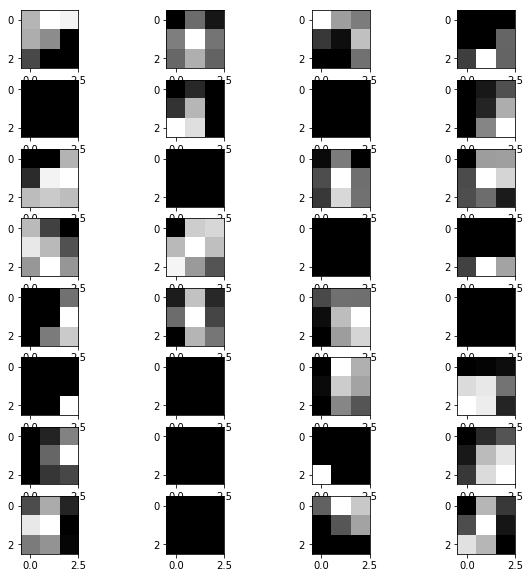

In [9]:
## This is what the 3X3 reduction looks like
plt.figure(figsize=(10, 10))

image_index = 13
#z_loc, z_scale, features, torches = vae.encoder.forward(train_loader.dataset[0][0].unsqueeze_(0))
test_x =  train_loader.dataset[image_index][0]

if train_loader.dataset[image_index][0].dim() == 4:
    test_x = test_x
elif train_loader.dataset[image_index][0].dim() == 3:
    test_x =  train_loader.dataset[image_index][0].unsqueeze(0)
elif train_loader.dataset[image_index][0].dim() == 5:
    test_x =  train_loader.dataset[image_index][0].squeeze(0)
    



for j in range(32):
    z_loc, z_scale, features, torches = vae.encoder.forward(test_x)
    if max(torches[j][0]) > 0:
        scaled_torch = (torches[j][0]/max(torches[j][0])).view(3,3)
    else:
        scaled_torch = torch.zeros(9).view(3,3)
    x_to_plot = scaled_torch.unsqueeze(0).detach().numpy()
    plt.subplot(8, 4, j+1)
    plt.imshow(x_to_plot[0,:,:], cmap = 'gray')
    
    

In [21]:
# Save the parameters
#torch.save(vae.state_dict(), "vae")

## VAE Model Convergence
Now that we have a trained model, we want to see if the hyperparameters allowed for the {\color{red} minimization of the loss function/ negative ELBO}. Graphically, we want to look for...
"Plot the results from part a"

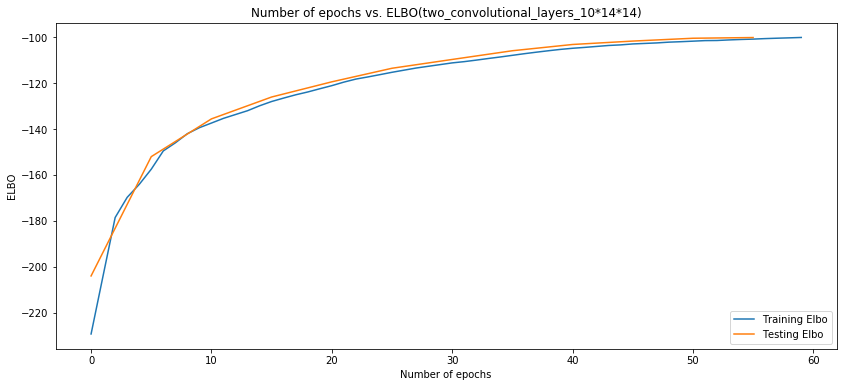

In [10]:
#Plot of the ELBO Function

xval1 = range(0,len(train_elbo)) # Number of training epochs
xval2 = range(0,len(train_elbo),TEST_FREQUENCY) # Number of testing epochs
plt.figure(figsize=(14,6)) # Control figure size
plt.plot(xval1, train_elbo,label = 'Training Elbo')
plt.plot(xval2, test_elbo ,label = 'Testing Elbo')
plt.title('Number of epochs vs. ELBO(two_convolutional_layers_10*14*14)')
plt.xlabel('Number of epochs')
plt.ylabel('ELBO')
plt.legend(loc='lower right')
plt.show()
#plt.savefig('Number of epochs vs. ELBO.png')

# LDA


In [11]:
## Extacting the feature vectors from the model for the LDA
test_x = train_loader.dataset[0][0]
z_loc, z_scale, features, torches = vae.encoder.forward(test_x.unsqueeze_(0))
unscaled = np.array(features.tolist()[0])
scaled = unscaled / (sum(unscaled))
p = np.floor(scaled*1000)
p =p.astype(int).tolist()


length_feature_vector = len(p)

#You must set the number of rows in the dataset you are running.
nrows=len(train_subset)

doc_word = np.empty([nrows,length_feature_vector])
doc_word[0] = p
for i in range(1, nrows):
    z_loc, z_scale, features, torches = vae.encoder.forward(train_loader.dataset[i][0].unsqueeze_(0))
    unscaled = np.array(features.tolist()[0])
    scaled = unscaled / (sum(unscaled))
    p = np.floor(scaled*1000)
    p                                                                                                                                                                                                                                                                                                                                                                                                   =p.astype(int).tolist()
    doc_word[i] = p
    
doc_word = doc_word.astype(int)
np.shape(doc_word)

(18623, 32)

In [12]:
##Running the LDA model

import lda 
from scipy.sparse import coo_matrix

data = doc_word
#Change preset number of iterations?
model = lda.LDA(n_topics=3, n_iter=LDA_iter, random_state=1, refresh = 100)

model.fit(data)

topic_word = model.topic_word_
n_top_words = 3

titles = np.array([str(i) for i in range(len(train_loader.dataset))])
vocab = np.array([str(i) for i in range(length_feature_vector)])


INFO:lda:n_documents: 18623
INFO:lda:vocab_size: 32
INFO:lda:n_words: 18353648
INFO:lda:n_topics: 3
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -77526064
INFO:lda:<100> log likelihood: -64635178
INFO:lda:<200> log likelihood: -64258740
INFO:lda:<300> log likelihood: -64006901
INFO:lda:<400> log likelihood: -63893045
INFO:lda:<500> log likelihood: -63814755
INFO:lda:<600> log likelihood: -63749546
INFO:lda:<700> log likelihood: -63697749
INFO:lda:<800> log likelihood: -63675880
INFO:lda:<900> log likelihood: -63665068
INFO:lda:<1000> log likelihood: -63686701
INFO:lda:<1100> log likelihood: -63682525
INFO:lda:<1200> log likelihood: -63657379
INFO:lda:<1300> log likelihood: -63651353
INFO:lda:<1400> log likelihood: -63627802
INFO:lda:<1500> log likelihood: -63640233
INFO:lda:<1600> log likelihood: -63627496
INFO:lda:<1700> log likelihood: -63596875
INFO:lda:<1800> log likelihood: -63594631
INFO:lda:<1900> log likelihood: -63558234
INFO:lda:<1999> log likelihood: -63564597


In [13]:
# For each of the 3 topics we have 32 topic words

model.doc_topic_[1]
len(model.topic_word_[1])
model.nz_

array([8234282, 4822034, 5297332], dtype=int32)

In [14]:
## Some LDA Topic results
num_examples = 10


doc_word = doc_word.astype(int)

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

doc_topic = model.doc_topic_
for i in range(num_examples):
	print("Image {} (top topic: {})".format(titles[i], doc_topic[i].argmax()))

Topic 0: 16 13 23
Topic 1: 1 7 3
Topic 2: 18 12 1
Image 0 (top topic: 0)
Image 1 (top topic: 1)
Image 2 (top topic: 0)
Image 3 (top topic: 1)
Image 4 (top topic: 1)
Image 5 (top topic: 1)
Image 6 (top topic: 2)
Image 7 (top topic: 0)
Image 8 (top topic: 1)
Image 9 (top topic: 0)


In [15]:
## The Confusuion Matrix

Num_all = [[] for i in range(3)]
doc_topic = model.doc_topic_

for i in range(3):
    for j in range(len(train_loader.dataset)):
        if train_loader.dataset[j][1]==i:
            Num_all[i]+=[doc_topic[j].argmax()] 

distribution = np.zeros([3,3])
for i,true_val in enumerate(Num_all):
    for j,pred_class in enumerate(Num_all[i]):
        distribution[i][pred_class]+=1
        
print(distribution.astype(int))

[[5644    6  273]
 [ 403 6147  192]
 [2126    8 3824]]


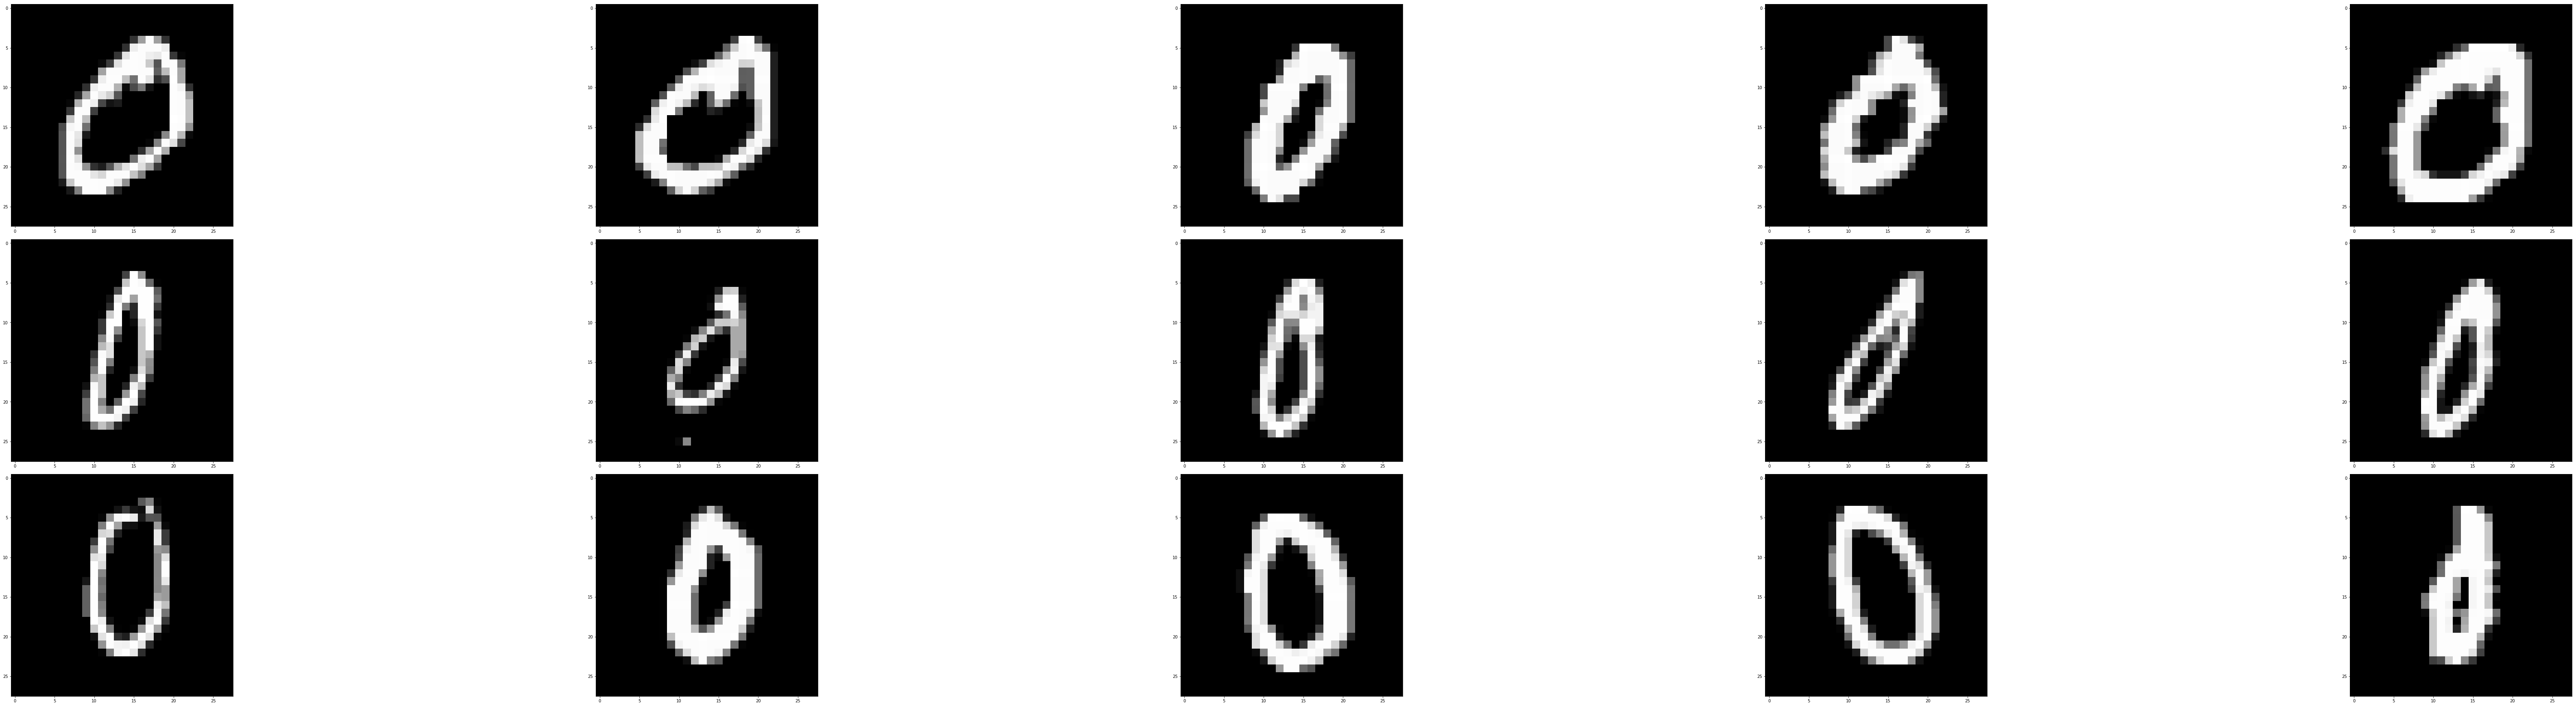

In [16]:
### Potting the 0s, each row represents a different topic

k = 0
plt.figure(figsize=(100, 40))
num_examp = 5

for group_num in range(3):
    j = 0
    while j <3:
        i=0
        while i < num_examp and j < len(train_loader.dataset):
            if doc_topic[j].argmax() == group_num and  train_loader.dataset[j][1]==k:
                plt.subplot(num_examp, num_examp, i + group_num*num_examp+1)
                plt.imshow(train_loader.dataset[j][0].reshape(28, 28), cmap="gray")
                i+=1
            j+=1
plt.tight_layout()


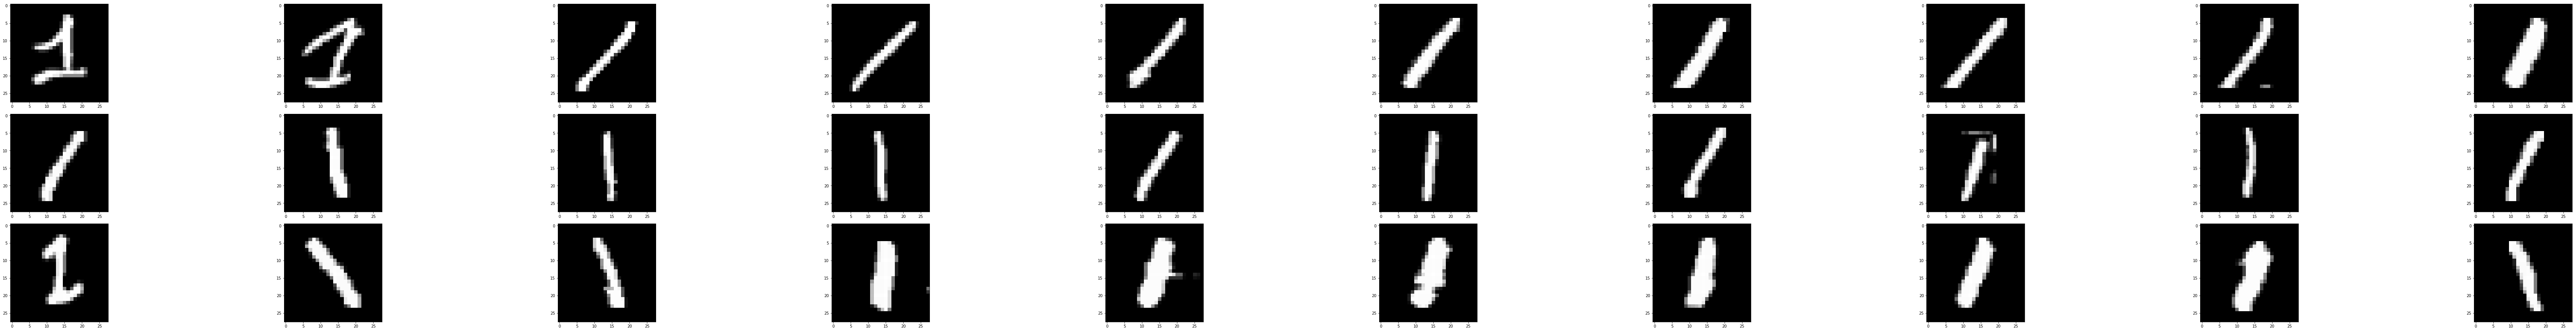

In [19]:
### Potting the 1s, each row represents a different topic

k = 1
plt.figure(figsize=(100, 40))
num_examp = 10

for group_num in range(3):
    j = 0
    while j <3:
        i=0
        while i < num_examp and j < len(train_loader.dataset):
            if doc_topic[j].argmax() == group_num and  train_loader.dataset[j][1]==k:
                plt.subplot(num_examp, num_examp, i + group_num*num_examp+1)
                plt.imshow(train_loader.dataset[j][0].reshape(28, 28), cmap="gray")
                i+=1
            j+=1
plt.tight_layout()

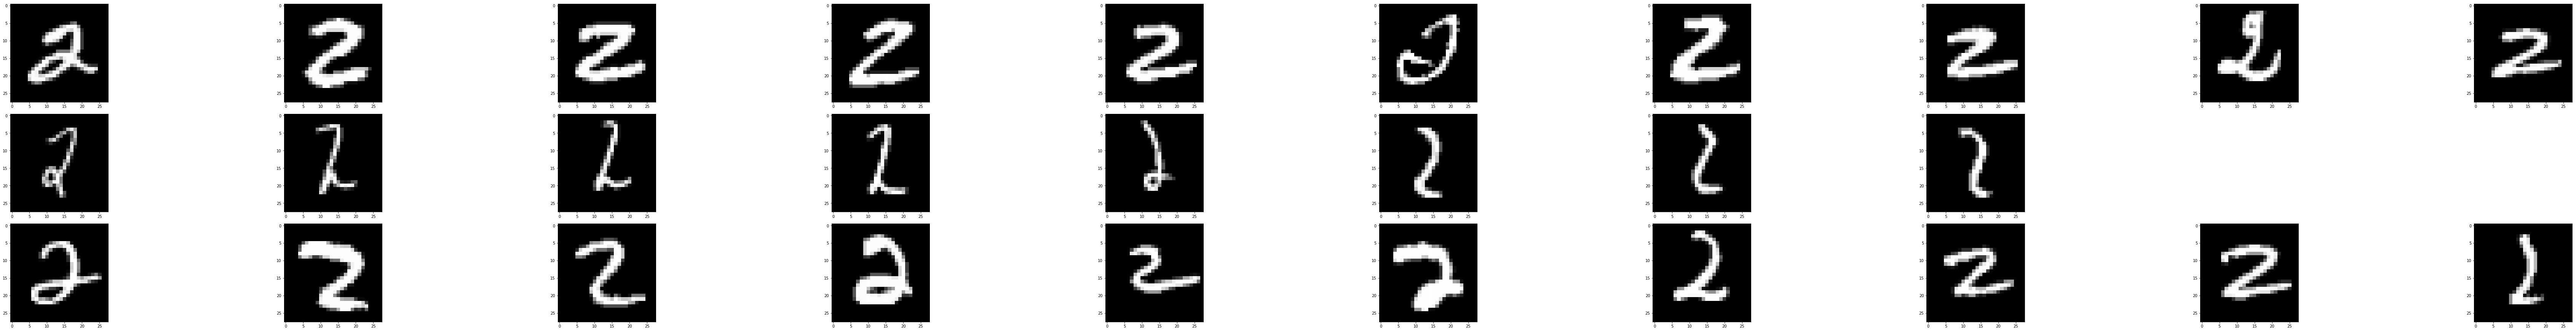

In [20]:
### Potting the 2s, each row represents a different topic

k = 2
plt.figure(figsize=(100, 40))
num_examp = 10

for group_num in range(3):
    j = 0
    while j <3:
        i=0
        while i < num_examp and j < len(train_loader.dataset):
            if doc_topic[j].argmax() == group_num and  train_loader.dataset[j][1]==k:
                plt.subplot(num_examp, num_examp, i + group_num*num_examp+1)
                plt.imshow(train_loader.dataset[j][0].reshape(28, 28), cmap="gray")
                i+=1
            j+=1
plt.tight_layout()